# KLUE Relation Extraction - 모델 비교 (Base vs Fine-tuned)


## 1. 환경 설정


In [1]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import importlib.util as _importlib_util
import sys as _sys

def _disable_torchvision():
    _sys.modules.pop("torchvision", None)
    _orig_find_spec = _importlib_util.find_spec
    def _patched_find_spec(name, *args, **kwargs):
        if name == "torchvision":
            return None
        return _orig_find_spec(name, *args, **kwargs)
    _importlib_util.find_spec = _patched_find_spec

try:
    import torchvision  # noqa: F401
    _ = torchvision.ops.nms
except Exception:
    _disable_torchvision()

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers.trainer_utils import get_last_checkpoint


## 2. 데이터 로드


In [2]:
valid_path = 'data/klue_re_valid_processed.csv'
valid_df = pd.read_csv(valid_path)

# 컬럼명 정합
if 'label_id' not in valid_df.columns and 'label' in valid_df.columns:
    valid_df['label_id'] = valid_df['label']

print(valid_df.head())
print('Valid:', len(valid_df))


                   guid                                         input_text  \
0  klue-re-v1_dev_00000  20대 남성 [SUBJ]A[/SUBJ](26)씨가 아버지 치료비를 위해 B([OBJ...   
1  klue-re-v1_dev_00001  그러나 [SUBJ]심 의원[/SUBJ]은 보좌진이 접속 권한을 받아 [OBJ]정부[...   
2  klue-re-v1_dev_00002  영화 《룸》에서 감금되어 살아가는 여자의 아들 '[SUBJ]잭[/SUBJ]' 역으로...   
3  klue-re-v1_dev_00003  전라남도([OBJ]도지사[/OBJ] 김영록)는 [SUBJ]해양수산부[/SUBJ]의 ...   
4  klue-re-v1_dev_00004  [SUBJ]부산항만공사[/SUBJ](BPA, 사장 남기찬)는 [OBJ]27일[/OB...   

   label  label_id  
0      0         0  
1      0         0  
2      0         0  
3      0         0  
4      0         0  
Valid: 7765


## 3. Dataset 정의


In [3]:
MODEL_NAME = 'klue/roberta-base'
MAX_LEN = 256

class KLUEREDataset:
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df['input_text'].tolist()
        self.labels = df['label_id'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


## 4. 평가 함수 및 헬퍼


In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
valid_dataset = KLUEREDataset(valid_df, tokenizer, MAX_LEN)
num_labels = int(valid_df['label_id'].nunique())


def compute_metrics_from_logits(logits, labels):
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    micro_f1 = f1_score(labels, preds, average='micro')
    return {'accuracy': acc, 'macro_f1': macro_f1, 'micro_f1': micro_f1}, preds


def evaluate_model(model, tag, out_root):
    args = TrainingArguments(
        output_dir=os.path.join(out_root, 'tmp'),
        per_device_eval_batch_size=16,
        eval_strategy='no',
        logging_strategy='no',
        report_to=[],
    )
    trainer = Trainer(model=model, args=args, eval_dataset=valid_dataset)
    pred_output = trainer.predict(valid_dataset)
    metrics, preds = compute_metrics_from_logits(pred_output.predictions, pred_output.label_ids)
    metrics['tag'] = tag

    # save confusion matrix
    cm = confusion_matrix(pred_output.label_ids, preds, labels=list(range(num_labels)))
    cm_df = pd.DataFrame(cm)
    os.makedirs(out_root, exist_ok=True)
    cm_df.to_csv(os.path.join(out_root, f'confusion_matrix_{tag}.csv'), index=False)

    plt.figure(figsize=(8, 7))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'Confusion Matrix - {tag}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(out_root, f'confusion_matrix_{tag}.png'), dpi=150)
    plt.show()

    return metrics


## 5. Base 모델 vs Fine-tuned 체크포인트 비교


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: klue/roberta-base
Key                             | Status     | 
--------------------------------+------------+-
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
/home/ai/jyk/ezcaretec/.localvenv/lib/python3.12/site-packages/torch/autograd/function.py:583: UserWarning:

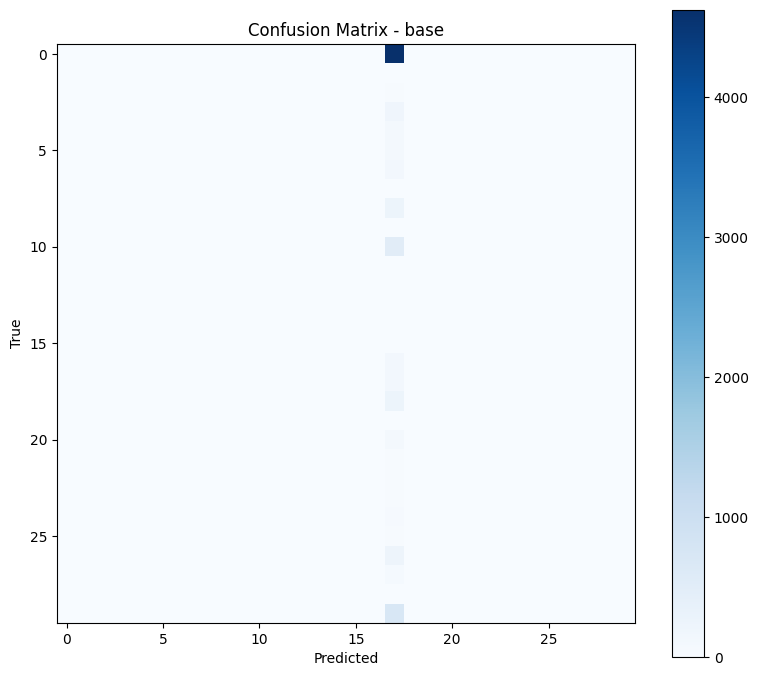

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

/home/ai/jyk/ezcaretec/.localvenv/lib/python3.12/site-packages/torch/autograd/function.py:583: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  return super().apply(*args, **kwargs)  # type: ignore[misc]


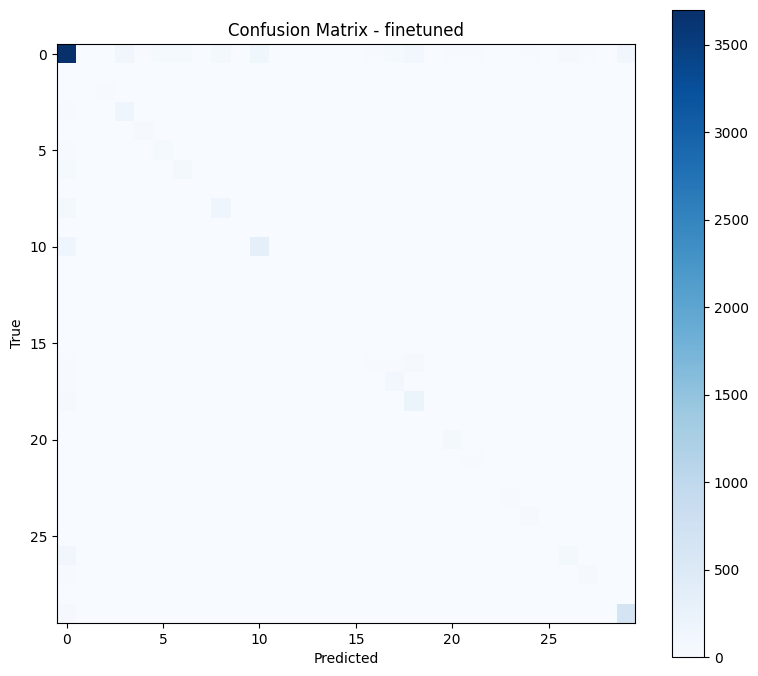

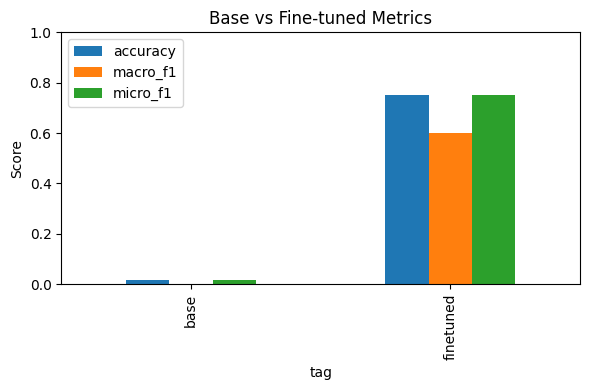

Saved comparison to: temp_result/07_model_comparison


,accuracy,macro_f1,micro_f1
tag,,,
base,0.015196,0.00100,0.015196
finetuned,0.749388,0.59924,0.749388


In [5]:
output_root = 'temp_result/07_model_comparison'
os.makedirs(output_root, exist_ok=True)

# Base 모델 (학습 전)
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)
base_metrics = evaluate_model(base_model, 'base', output_root)

# Fine-tuned 체크포인트 로드
ckpt_root = 'temp_result/06_klue_re_training/baseline'
ckpt_path = get_last_checkpoint(ckpt_root)
if ckpt_path is None:
    raise RuntimeError('No checkpoint found in temp_result/06_klue_re_training/baseline')

ft_model = AutoModelForSequenceClassification.from_pretrained(ckpt_path)
ft_metrics = evaluate_model(ft_model, 'finetuned', output_root)

# 비교 요약 저장
metrics_df = pd.DataFrame([base_metrics, ft_metrics]).set_index('tag')
metrics_df.to_csv(os.path.join(output_root, 'metrics_comparison.csv'), encoding='utf-8')
with open(os.path.join(output_root, 'metrics_comparison.json'), 'w', encoding='utf-8') as f:
    json.dump(metrics_df.to_dict(orient='index'), f, ensure_ascii=False, indent=2)

# 시각화
metrics_df[['accuracy', 'macro_f1', 'micro_f1']].plot(kind='bar', figsize=(6, 4))
plt.title('Base vs Fine-tuned Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(output_root, 'metrics_comparison.png'), dpi=150)
plt.show()

print('Saved comparison to:', output_root)
metrics_df


## 6. 요약 (해석 및 논리)
- **학습 전(Base) 모델이 거의 랜덤 수준인 이유**: `klue/roberta-base`는 사전학습 언어모델이며, 분류용 `classifier`는 랜덤 초기화 상태입니다. 즉, RE 라벨에 대한 학습이 전혀 없으므로 예측이 사실상 무작위에 가깝고 accuracy≈0.015, macro F1≈0.001로 나타났습니다. 이는 30‑클래스 문제에서 학습 없이 분류 성능을 기대할 수 없음을 보여줍니다.
- **Fine‑tuned 모델 성능이 크게 오른 이유**: 체크포인트는 KLUE‑RE 학습으로 분류 head와 본문 인코더가 함께 업데이트된 결과입니다. 학습 과정에서 문장 내 두 엔티티 관계 패턴을 파악하도록 가중치가 최적화되었고, 그 결과 accuracy≈0.749, macro F1≈0.599까지 상승했습니다. 즉, 모델이 실제 과제 신호(관계 유형)를 학습했음을 의미합니다.
- **macro F1 < accuracy의 해석**: KLUE‑RE는 클래스 불균형이 크고(특히 `no_relation`이 대다수), accuracy/micro F1은 다수 클래스 정답 비율에 민감합니다. 반면 macro F1은 각 클래스를 동일 가중으로 평균하므로 소수 클래스 성능이 낮으면 크게 떨어집니다. 따라서 높은 accuracy에도 불구하고 macro F1이 상대적으로 낮게 나온 것은 소수 관계 유형에서 여전히 오분류가 많다는 신호입니다.
- **실무적 결론**: (1) 사전학습 모델만으로는 RE 과제 해결이 어렵고 **fine‑tuning이 필수**이며, (2) 모델은 전반적으로 유의미한 성능 향상을 보였으나, (3) 클래스 불균형으로 인해 **소수 클래스 개선 여지**가 남아 있습니다. 향후 개선 방향으로는 class‑weighted loss, 데이터 증강, 샘플링 전략, 라벨별 오류 분석 등이 타당합니다.
